In [1]:
from fptools import fp, stochastic, bayes
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy

# NP/S vs. NP/Z garden paths according to Sturt et al. 1999

Updates to existing structure that preserve dominance relations between words ("monotonic updates") should be easier than changing dominance relations ("non-monotonic updates")

1. NP/S: The woman saw [that] the doctor had been drinking.
2. NP/Z: Before the woman visited[,] the doctor had been drinking.

For NP/S, we need the dominance relations: 
1. At ambiguity: saw > doctor
2. After disambiguating by inserting had: saw > had, had > doctor

For unambiguous NP/S:
1. No dominance between saw and doctor
2. Insert saw > had and had > doctor

By transitivity of >, *saw* still dominates *doctor*

For NP/Z, we need the dominance relations: 
1. At ambiguity: visited > doctor
2. After disambiguating: had > doctor, had > visited

For unambiguous NP/Z:
1. No dominance between *visited* and *doctor*
2. Insert *had* > *visited* and *had* > *doctor*

For NP/Z, need to completely undo dominance relations, whereas for NP/S, just need to insert



In [2]:
npsambstates = """saw>doc, saw>had_saw>doc, 0.9
saw>had_saw>doc, abs, 1.0
"""
npsidx, _, _, npsW, npsT, npsA, _, _ = fp.make_sys(npsambstates)
#print(ambidx, ambW)

npsunambstates = """null, saw>had_saw>doc, 1.0
saw>had_saw>doc, abs, 1.0
"""
npsunidx, _, _, npsunW, npsunT, npsunA, _, _ = fp.make_sys(npsunambstates)

npzambstates = """vis>doc, null, 1.0
null, had>doc_had>vis, 1.0
had>doc_had>vis, abs, 1.0
"""
npzidx, _, _, npzW, npzT, npzA, _, _ = fp.make_sys(npzambstates)
#print(ctlidx, ctlW)

npzunambstates = """null, had>doc_had>vis, 1.0
had>doc_had>vis, abs, 1.0
"""
npzunidx, _, _, npzunW, npzunT, npzunA, _, _ = fp.make_sys(npzunambstates)

In [3]:
condnames = ['NP/S', 'NP/S control', 'NP/Z', 'NP/Z control']
conds = [[npsT, npsA, npsW], [npsunT, npsunA, npsunW], [npzT, npzA, npzW], [npzunT, npzunA, npzunW]]

for i in range(len(condnames)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[0] = 1.0
    print('{}:\n\tmean: {}, variance: {}'.format(condnames[i], *np.round(fp.meanvar(conds[i][0], p0), 6)))

NP/S:
	mean: 0.703704, variance: 0.248285
NP/S control:
	mean: 0.666667, variance: 0.222222
NP/Z:
	mean: 0.75, variance: 0.1875
NP/Z control:
	mean: 0.666667, variance: 0.222222


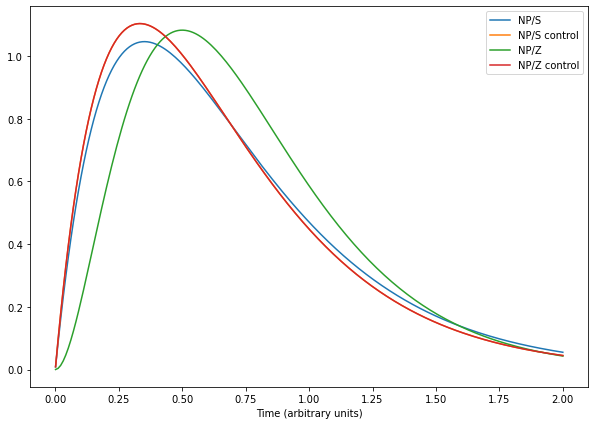

In [4]:
tvec = np.linspace(0.001, 2, 200)
plt.figure(figsize=(10, 7))
for i in range(len(conds)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[0] = 1.0
    plt.plot(tvec, [fp.etd(t, conds[i][0], conds[i][1], p0) for t in tvec], label=condnames[i])
    #plt.plot(tvec, [fp.cfptd(t, conds[i][0], conds[i][1], p0) for t in tvec], label=condnames[i])
plt.legend()
plt.xlabel('Time (arbitrary units)')
plt.show()

In [5]:
# Generating stochastic runs
stoch = []
for i in range(len(conds)):
     stoch.append(stochastic.rep_ssa(conds[i][-1], n=2000))

Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 11882.35it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 12471.76it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 9131.58it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 12713.09it/s]


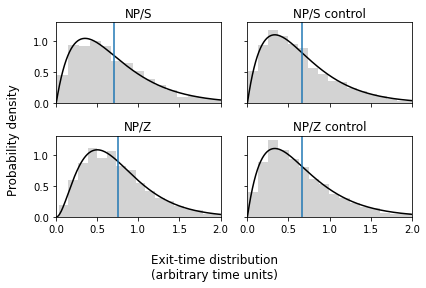

In [10]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, squeeze=True, figsize=(6,4))
for i in range(len(conds)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[0] = 1.0
    axs.flat[i].plot(tvec, [fp.etd(t, conds[i][0], conds[i][1], p0) for t in tvec], color='k')
    axs.flat[i].hist(stoch[i]['fpt'], density=True, bins=25, color='lightgrey')
    axs.flat[i].set_title(condnames[i])
    axs.flat[i].set_xlim(0, max(tvec))
    axs.flat[i].axvline(fp.meanvar(conds[i][0], p0)[0])
fig.supxlabel('Exit-time distribution\n(arbitrary time units)')
fig.supylabel('Probability density')
fig.tight_layout()
fig.savefig('gpetd.pdf')
plt.show()